## Analysing Goodreads ratings - Artificial Intelligence project
### EDA -Exploratory Data Analysis
Daniela Stern-Gabsi


In [62]:
#Import necessary packages
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
plt.style.use('ggplot')

KeyError: 'xticklabels.rotation is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [38]:
#load configuration file
try:
    with open('configuration.yml', 'r') as file:
        conf = yaml.load(file, Loader=yaml.FullLoader)
except Exception as e:
    print('Error reading the config file')

In [37]:
conf

{'data_files': {'data_dir': 'data',
  'ratings_file': 'goodreads_interactions.csv',
  'books_authors_file': 'goodreads_book_authors.json',
  'books_works_file': 'goodreads_book_works.json',
  'books_genres_file': 'goodreads_book_genres_initial.json'}}

Loading the data files

In [39]:
#Loading the data to pandas dataframes
rating_file=os.path.join(conf["files"]["data_dir"],conf["files"]["ratings_file"])
ratings=pd.read_csv(rating_file)
authors_file=os.path.join(conf["files"]["data_dir"],conf["files"]["books_authors_file"])
authors=pd.read_json(authors_file, lines=True)
works_file=os.path.join(conf["files"]["data_dir"],conf["files"]["books_works_file"])
works=pd.read_json(authors_file, lines=True)
genres_file=os.path.join(conf["files"]["data_dir"],conf["files"]["books_genres_file"])
genres=pd.read_json(genres_file, lines=True)


First we will explore the rating data which consists of the interactions between the if user and books:
Each user can rate a book in ascending order from zero to five .Zero rate means the users hasnt rated the book. User can also
add a review on the book .

In [42]:
print(ratings.head())
print(ratings.info())
print(ratings.describe())
print(ratings.isnull().any())

   user_id  book_id  is_read  rating  is_reviewed
0        0      948        1       5            0
1        0      947        1       5            1
2        0      946        1       5            0
3        0      945        1       5            0
4        0      944        1       5            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   book_id      int64
 2   is_read      int64
 3   rating       int64
 4   is_reviewed  int64
dtypes: int64(5)
memory usage: 8.5 GB
None
            user_id       book_id       is_read        rating   is_reviewed
count  2.286483e+08  2.286483e+08  2.286483e+08  2.286483e+08  2.286483e+08
mean   2.500636e+05  2.015756e+05  4.904090e-01  1.801340e+00  7.093491e-02
std    1.712713e+05  3.448677e+05  4.999080e-01  2.072672e+00  2.567161e-01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.0000

We can see that there are no null values.
Lets look at the rating distribution


[Text(0, 0, '0'), Text(1, 0, '1')]

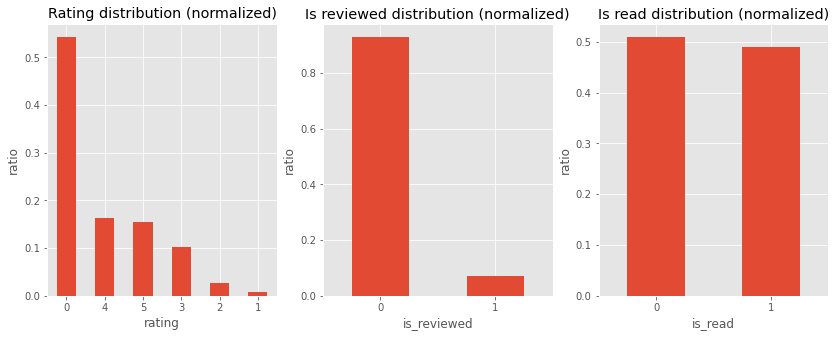

In [67]:
figure, axes = plt.subplots(1,3,figsize=(14,5))
ratings["rating"].value_counts(normalize=True).plot(kind='bar',ax=axes[0])
axes[0].set_title("Rating distribution (normalized)")
axes[0].set_ylabel("ratio")
axes[0].set_xlabel("rating")
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=0)
ratings["is_reviewed"].value_counts(normalize=True).plot(kind='bar',ax=axes[1])
axes[1].set_title("Is reviewed distribution (normalized)")
axes[1].set_ylabel("ratio")
axes[1].set_xlabel("is_reviewed")
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=0)
ratings["is_read"].value_counts(normalize=True).plot(kind='bar',ax=axes[2])
axes[2].set_title("Is read distribution (normalized)")
axes[2].set_ylabel("ratio")
axes[2].set_xlabel("is_read")
axes[2].set_xticklabels(axes[2].get_xticklabels(),rotation=0)

In [68]:
print(authors.head())
print(authors.info())
print(authors.describe())
print(authors.isnull().any())


   average_rating  author_id  text_reviews_count              name  \
0            3.98     604031                   7  Ronald J. Fields   
1            4.08     626222               28716     Anita Diamant   
2            3.92      10333                5075    Barbara Hambly   
3            3.68       9212               36262   Jennifer Weiner   
4            3.82     149918                  96     Nigel Pennick   

   ratings_count  
0             49  
1         546796  
2         122118  
3         888522  
4           1740  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   average_rating      829529 non-null  float64
 1   author_id           829529 non-null  int64  
 2   text_reviews_count  829529 non-null  int64  
 3   name                829529 non-null  object 
 4   ratings_count       829529 non-null  int64  
dtype

In [69]:
print(works.head())
print(works.info())
print(works.describe())
print(works.isnull().any())

   average_rating  author_id  text_reviews_count              name  \
0            3.98     604031                   7  Ronald J. Fields   
1            4.08     626222               28716     Anita Diamant   
2            3.92      10333                5075    Barbara Hambly   
3            3.68       9212               36262   Jennifer Weiner   
4            3.82     149918                  96     Nigel Pennick   

   ratings_count  
0             49  
1         546796  
2         122118  
3         888522  
4           1740  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829529 entries, 0 to 829528
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   average_rating      829529 non-null  float64
 1   author_id           829529 non-null  int64  
 2   text_reviews_count  829529 non-null  int64  
 3   name                829529 non-null  object 
 4   ratings_count       829529 non-null  int64  
dtype

In [70]:
print(genres.head())
print(genres.info())
print(genres.describe())
print(genres.isnull().any())

   book_id                                             genres
0  5333265      {'history, historical fiction, biography': 1}
1  1333909  {'fiction': 219, 'history, historical fiction,...
2  7327624  {'fantasy, paranormal': 31, 'fiction': 8, 'mys...
3  6066819  {'fiction': 555, 'romance': 23, 'mystery, thri...
4   287140                                 {'non-fiction': 3}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2360655 entries, 0 to 2360654
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   book_id  int64 
 1   genres   object
dtypes: int64(1), object(1)
memory usage: 36.0+ MB
None
            book_id
count  2.360655e+06
mean   1.540953e+07
std    1.081897e+07
min    1.000000e+00
25%    5.979046e+06
50%    1.585681e+07
75%    2.438194e+07
max    3.653043e+07
book_id    False
genres     False
dtype: bool


In [71]:
ratings["is_rated"]=ratings["rating"]>0

ratings["is_read"].corr(ratings["is rated"])


0.9356568943515737

In [ ]:
ratings.head()

,user_id,book_id,is_read,rating,is_reviewed,is rated
0,0,948,1,5,0,True
1,0,947,1,5,1,True
2,0,946,1,5,0,True
3,0,945,1,5,0,True
4,0,944,1,5,0,True
